# PV power production forecasting model

First things first.
we've got 40 kW PV array near Las Vegas. PV elements are Sharp NU-U240F1 x. 
Data is collected every 15 minutes: Weather conditions, Voltage, Current and Power output of PV system.

They were colecting data since 2011 to our days, but quite a lot of the data has missing values in it. After short consideration i decided to use data from 2012 to 2014.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df1 = pd.read_csv('pvdaq_data_1277_2012.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])
df2 = pd.read_csv('pvdaq_data_1277_2013.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])
df3 = pd.read_csv('pvdaq_data_1277_2014.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [0]:
df = pd.concat([df1, df2, df3])
df.shape, df1.shape, df2.shape, df3.shape

((105231, 16), (35140, 16), (35044, 16), (35047, 16))

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105231 entries, 2012-01-01 00:00:00 to 2014-12-31 23:45:00
Data columns (total 16 columns):
SiteID                 105231 non-null int64
ac_current             105192 non-null float64
ac_power               105192 non-null float64
ac_voltage             105192 non-null float64
ambient_temp           101525 non-null float64
dc_current             105192 non-null float64
dc_power               105192 non-null float64
dc_voltage             105192 non-null float64
inverter_error_code    105231 non-null int64
inverter_temp          105192 non-null float64
module_temp            101525 non-null float64
poa_irradiance         101525 non-null float64
power_factor           105192 non-null float64
relative_humidity      101525 non-null float64
wind_direction         101525 non-null float64
wind_speed             101525 non-null float64
dtypes: float64(14), int64(2)
memory usage: 13.6 MB


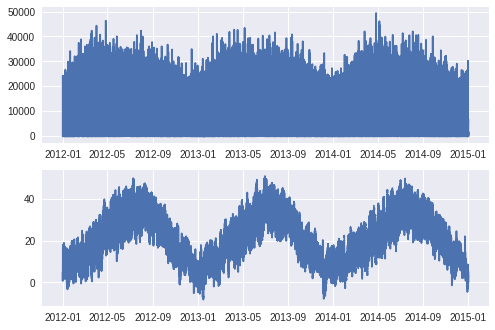

In [0]:
plt.subplot(211)
plt.plot(df.index, df['dc_power'])
plt.subplot(212)
plt.plot(df.index, df['ambient_temp'])

In [0]:
df.isnull().sum()

SiteID                    0
ac_current               39
ac_power                 39
ac_voltage               39
ambient_temp           3706
dc_current               39
dc_power                 39
dc_voltage               39
inverter_error_code       0
inverter_temp            39
module_temp            3706
poa_irradiance         3706
power_factor             39
relative_humidity      3706
wind_direction         3706
wind_speed             3706
dtype: int64

In [0]:
df.index[df.isnull().any(axis=1)].year.value_counts()

2014    3346
2013     362
2012      19
Name: Date-Time, dtype: int64

Data is mostly clean(not counting missing 10% in 2014), there is some missing data, but we can restore this data by interpolation. 
https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460


In [0]:
df_filled = pd.DataFrame()
for col in df.columns:  
  df_filled[col] = df[col].interpolate(method='slinear')

In [0]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105231 entries, 2012-01-01 00:00:00 to 2014-12-31 23:45:00
Data columns (total 16 columns):
SiteID                 105231 non-null int64
ac_current             105231 non-null float64
ac_power               105231 non-null float64
ac_voltage             105231 non-null float64
ambient_temp           105231 non-null float64
dc_current             105231 non-null float64
dc_power               105231 non-null float64
dc_voltage             105231 non-null float64
inverter_error_code    105231 non-null int64
inverter_temp          105231 non-null float64
module_temp            105231 non-null float64
poa_irradiance         105231 non-null float64
power_factor           105231 non-null float64
relative_humidity      105231 non-null float64
wind_direction         105231 non-null float64
wind_speed             105231 non-null float64
dtypes: float64(14), int64(2)
memory usage: 13.6 MB


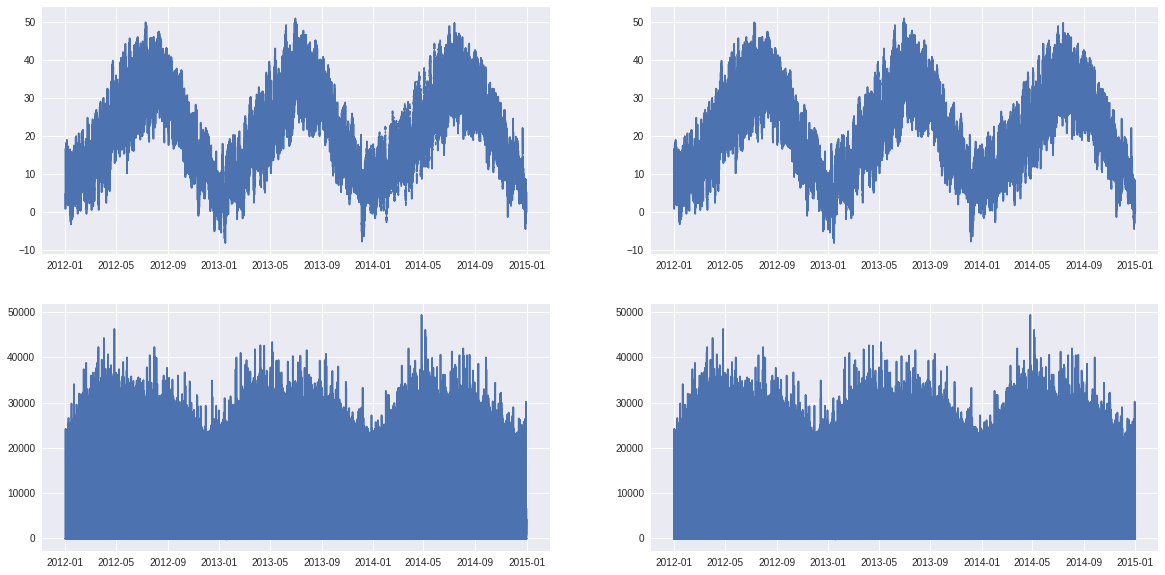

In [0]:
#print(df_filled.isnull().sum())
plt.subplots(figsize=(20, 10))
plt.subplot(221)
plt.plot(df.index, df['ambient_temp'])
plt.subplot(222)
plt.plot(df_filled.index, df_filled['ambient_temp'])
plt.subplot(223)
plt.plot(df.index, df['dc_power'])
plt.subplot(224)
plt.plot(df_filled.index, df_filled['dc_power'])

It would be better to resample our data from 15 minutes time step to hourly data.


In [0]:
df_resampled = df_filled.resample('1H').mean()

In [0]:
df_resampled.head(10)

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
Date-Time,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,1277.0,0.00,-150.0,285.50,4.437502,-1.00,-100.0,0.25,0.0,16.50,0.208335,0.00000,0.00000,44.62800,306.70350,0.565841
2012-01-01 01:00:00,1277.0,0.00,-125.0,285.50,3.668335,-1.00,-100.0,0.00,0.0,15.50,-1.299999,0.00000,0.00000,47.33125,306.72025,0.577687
2012-01-01 02:00:00,1277.0,0.00,-150.0,285.75,3.080418,-1.00,-100.0,0.25,0.0,14.50,-2.466665,0.00000,0.00000,46.12350,306.75950,0.518231
2012-01-01 03:00:00,1277.0,0.00,-175.0,284.50,2.910418,-1.00,-100.0,0.00,0.0,14.00,-2.327777,0.00000,0.00000,38.91425,307.95750,0.447711
2012-01-01 04:00:00,1277.0,0.00,-175.0,284.00,1.225696,-1.00,-100.0,0.00,0.0,13.00,-4.915277,0.00000,0.00000,44.56100,308.50275,0.345003
2012-01-01 05:00:00,1277.0,0.00,-125.0,283.50,1.020279,-1.00,-100.0,0.00,0.0,12.50,-5.013888,0.00000,0.00000,48.10175,308.52000,0.513425
2012-01-01 06:00:00,1277.0,0.25,-175.0,283.75,1.847224,-1.00,-125.0,150.75,0.0,12.25,-3.015277,0.43950,0.00000,42.71075,308.46975,0.829818
2012-01-01 07:00:00,1277.0,0.75,275.0,284.50,2.036946,0.75,325.0,351.75,0.0,18.75,-2.573610,31.46975,0.00000,43.89550,309.62275,0.422676
2012-01-01 08:00:00,1277.0,7.00,6525.0,284.50,3.589724,16.50,6700.0,403.00,0.0,35.00,7.587502,358.20325,0.73975,44.19525,310.61800,0.521807


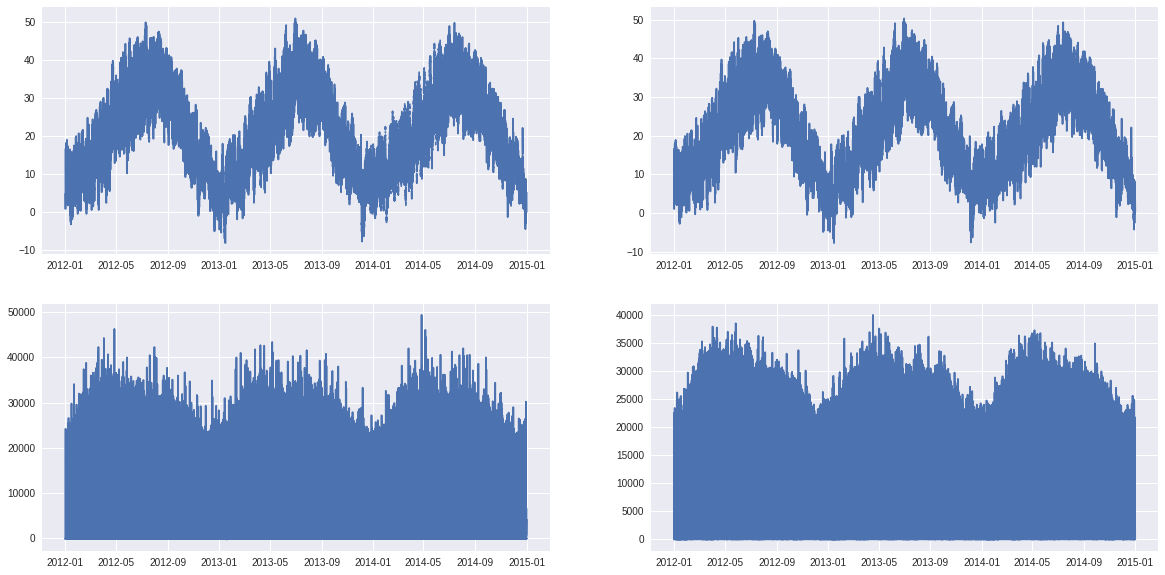

In [0]:
plt.subplots(figsize=(20, 10))
plt.subplot(221)
plt.plot(df.index, df['ambient_temp'])
plt.subplot(222)
plt.plot(df_resampled.index, df_resampled['ambient_temp'])
plt.subplot(223)
plt.plot(df.index, df['dc_power'])
plt.subplot(224)
plt.plot(df_resampled.index, df_resampled['dc_power'])

In [0]:
df_resampled.to_csv('pvdaq_2012_2014_hourly.csv')